In [175]:
import os
import glob
import cv2 
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import librosa
import librosa.display
from scipy import signal
import pywt

In [513]:
BATCH_SIZE = 2
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [509]:
train = pd.read_csv('mitbih_train.csv',header=None).astype(np.float32).values
test = pd.read_csv('mitbih_test.csv',header=None).astype(np.float32).values

In [543]:
def converttoSpectrogram(x,y_temp):
    
    #Selecting CMAP
    cmap = plt.get_cmap('CMRmap')    
    
    #Butterworth Filter
    sos = signal.butter(5, 25, 'lp', fs=125, output='sos')
    filtered = signal.sosfilt(sos, x)   
    
    #For ShortTerm Fourier Transform
    X = librosa.stft(filtered,n_fft=50)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=125,cmap=cmap)
    plt.savefig('temp.png', bbox_inches='tight')
    plt.close()
    #loading 
    stft = cv2.imread('temp.png')[:,:,[2,1,0]]
    os.remove('temp.png')
    
    '''    #For Mel SpectroGram 
    sgram_mag, _ = librosa.magphase(librosa.stft(filtered,n_fft=50))
    X = librosa.feature.melspectrogram(S=sgram_mag,sr=125,n_fft=50)
    Xdb = librosa.amplitude_to_db(X,ref=np.max)
    librosa.display.specshow(Xdb, sr=125,cmap=cmap)
    plt.savefig('temp.jpg', bbox_inches='tight')
    plt.close()
    #loading 
    mel = cv2.imread('temp.jpg')[:,:,[2,1,0]]
    os.remove('temp.jpg')'''
    
    #For Scalogram
    matrix = signal.cwt(filtered, signal.ricker, np.arange(1, 30))
    plt.imshow(matrix, extent=[-1, 1, 1, 31], cmap=cmap, aspect='auto',
           vmax=abs(matrix).max(), vmin=-abs(matrix).max())
    plt.axis('off')
    plt.savefig('temp.png', bbox_inches='tight')
    plt.close()
    #loading 
    scalo = cv2.imread('temp.png')[:,:,[2,1,0]]
    os.remove('temp.png')
    
    
    #FOR MFCC
    plt.imshow(mfcc(filtered, samplerate=125,nfft=50,winstep=0.1,winlen=0.3),cmap=cmap)
    plt.axis('off')
    plt.savefig('temp.png', bbox_inches='tight')
    plt.close()
    #loading 
    mfcc_spc = cv2.imread('temp.png')[:,:,[2,1,0]]
    os.remove('temp.png')
    
    return np.append(np.append(cv2.resize(stft,(128,128)),cv2.resize(scalo,(128,128)),axis=-1),cv2.resize(mfcc_spc,(128,128)),axis=-1),y_temp

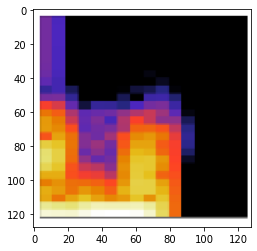

In [544]:
plt.imshow(converttoSpectrogram(train[30,:-1],[])[0][:,:,[0,1,2]])

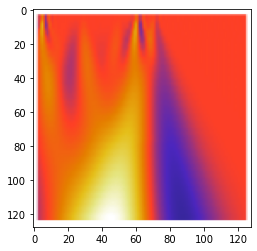

In [545]:
plt.imshow(converttoSpectrogram(train[30,:-1],[])[0][:,:,[3,4,5]])

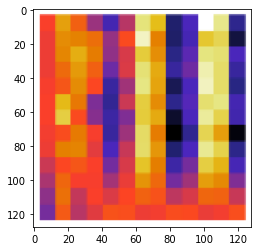

In [546]:
plt.imshow(converttoSpectrogram(train[30,:-1],[])[0][:,:,[6,7,8]])

In [547]:
def splitting_function(record):
    #print(path_decoded)
    x = record[:-1]
    y = record[-1]
    return converttoSpectrogram(x,y)

In [ ]:
spectro = list()
for i in tqdm(train):
    spectro.append(splitting_function(i))

 22%|████████████████                                                        | 19542/87554 [1:24:20<7:12:52,  2.62it/s]

In [548]:
def tf_reshape(img,y):
    return tf.reshape(img,(128,128,9)),tf.reshape(y,(1,))

In [549]:
spectrogram_wrapper = lambda x,y : tf.py_function(converttoSpectrogram,[x,y],[tf.float32,tf.float32])
splitting_wrapper = lambda x : tf.py_function(splitting_function,[x],[tf.float32,tf.float32])

In [550]:
def create_dataset(dataset):
    dataset = tf.data.Dataset.from_tensor_slices(dataset)
    dataset = dataset.map(splitting_wrapper, num_parallel_calls=AUTOTUNE)
    dataset = dataset.map(tf_reshape , num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

In [551]:
train_set = create_dataset(train)
test_set = create_dataset(test)


In [552]:
next(iter(train_set))

InvalidArgumentError: ValueError: Given element not contained in the stack
Traceback (most recent call last):

  File "C:\Users\vishw\anaconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 247, in __call__
    return func(device, token, args)

  File "C:\Users\vishw\anaconda3\lib\site-packages\tensorflow\python\ops\script_ops.py", line 135, in __call__
    ret = self._func(*args)

  File "C:\Users\vishw\anaconda3\lib\site-packages\tensorflow\python\autograph\impl\api.py", line 620, in wrapper
    return func(*args, **kwargs)

  File "<ipython-input-547-a14ffa1528d9>", line 5, in splitting_function
    return converttoSpectrogram(x,y)

  File "<ipython-input-543-f1625dbb4e0d>", line 13, in converttoSpectrogram
    librosa.display.specshow(Xdb, sr=125,cmap=cmap)

  File "C:\Users\vishw\anaconda3\lib\site-packages\librosa\display.py", line 980, in specshow
    axes = __check_axes(ax)

  File "C:\Users\vishw\anaconda3\lib\site-packages\librosa\display.py", line 1063, in __check_axes
    axes = plt.gca()

  File "C:\Users\vishw\anaconda3\lib\site-packages\matplotlib\pyplot.py", line 2368, in gca
    return gcf().gca(**kwargs)

  File "C:\Users\vishw\anaconda3\lib\site-packages\matplotlib\figure.py", line 2065, in gca
    return self.add_subplot(1, 1, 1, **kwargs)

  File "C:\Users\vishw\anaconda3\lib\site-packages\matplotlib\figure.py", line 1404, in add_subplot
    return self._add_axes_internal(key, ax)

  File "C:\Users\vishw\anaconda3\lib\site-packages\matplotlib\figure.py", line 1408, in _add_axes_internal
    self._axstack.add(key, ax)

  File "C:\Users\vishw\anaconda3\lib\site-packages\matplotlib\figure.py", line 125, in add
    super().remove((key, a_existing))

  File "C:\Users\vishw\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 643, in remove
    raise ValueError('Given element not contained in the stack')

ValueError: Given element not contained in the stack


	 [[{{node EagerPyFunc}}]]

Done: <matplotlib.backends.backend_agg.RendererAgg object at 0x000002DB626723D0>

<Figure size 432x288 with 1 Axes>

C:\Users\vishw\anaconda3\lib\site-packages\librosa\display.py:1011: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.sci(img)


## Making the Model

In [12]:
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Conv3D,Dense,MaxPool3D,ReLU,Input,concatenate,Flatten,BatchNormalization, Dropout, GlobalAveragePooling3D

In [13]:
#For low intensity segments
input_layer = Input(shape=(128,128,63,3),name='input')
model = Conv3D(filters=128*3, kernel_size=3, strides=2,padding='same', activation=None, groups = 3, name="GroupConv1")(input_layer)
model = BatchNormalization(center=True, scale=True)(model)
model = ReLU()(model)
model = Dropout(0.5)(model)

model = Conv3D(filters=128*3, kernel_size=3, strides=1,padding='same', activation=None , groups = 3, name="GroupConv2")(model)
model = BatchNormalization(center=True, scale=True)(model)
model = ReLU()(model)
model = Dropout(0.5)(model)

model = Conv3D(filters=256*3, kernel_size=3, strides=2,padding='same', activation=None, groups = 3, name="GroupConv3")(model)
model = BatchNormalization(center=True, scale=True)(model)
model = ReLU()(model)
model = Dropout(0.5)(model)

model = Conv3D(filters=256*3, kernel_size=3, strides=1,padding='same', activation=None , groups = 3, name="GroupConv4")(model)
model = BatchNormalization(center=True, scale=True)(model)
model = ReLU()(model)
model = Dropout(0.5)(model)

#Classification Network
classifier = Conv3D(filters=1024, kernel_size=3, strides=2,padding='same', activation=None)(model)
classifier = BatchNormalization(center=True, scale=True)(classifier)
classifier = ReLU()(classifier)
classifier = Dropout(0.5)(classifier)

flatten = GlobalAveragePooling3D()(classifier)

dense = Dense(256, activation='relu')(flatten)
output = Dense(1, activation='sigmoid')(dense)

In [14]:
model = Model(input_layer,output)

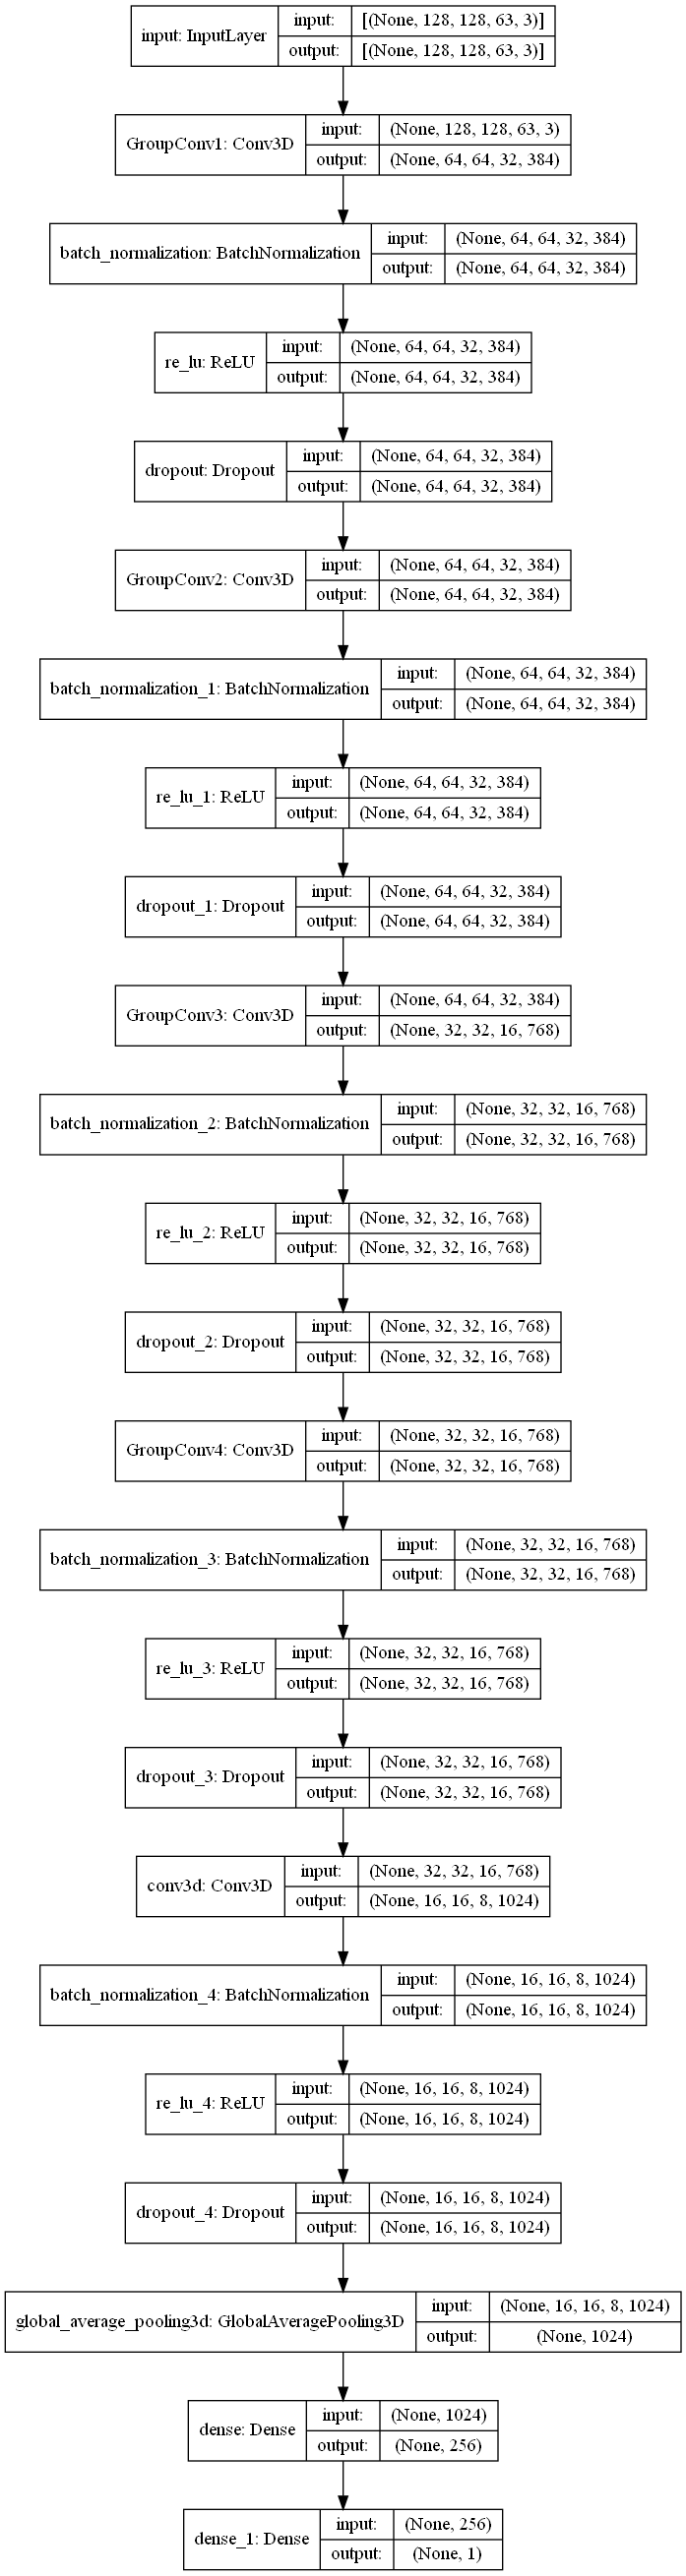

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True,show_layer_names=True,rankdir='TB',expand_nested=True)

In [16]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)
#opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

In [17]:
model.compile(optimizer=opt,loss=keras.losses.squared_hinge, metrics=['accuracy'])

In [18]:
model.fit(train_set,
          batch_size=BATCH_SIZE,
          epochs=20)

Epoch 1/20
214/214 [==============================] - 288s 1s/step - loss: 1.0191 - accuracy: 0.6223
Epoch 2/20
214/214 [==============================] - 273s 1s/step - loss: 1.0000 - accuracy: 0.6212
Epoch 3/20
214/214 [==============================] - 279s 1s/step - loss: 1.0000 - accuracy: 0.6212
Epoch 4/20
 43/214 [=====>........................] - ETA: 3:44 - loss: 1.0000 - accuracy: 0.6414

KeyboardInterrupt: 

In [19]:
model.save("PET_alzh.h5")

## Running the model

In [29]:
def getSegments_test(subject,y_temp):
    #subject = subject.numpy()
    
    ret,thresh_low = cv2.threshold(subject,0.20,1.0,cv2.THRESH_BINARY)
    ret,thresh_med = cv2.threshold(subject,0.40,1.0,cv2.THRESH_BINARY)
    ret,thresh_high = cv2.threshold(subject,0.60,1.0,cv2.THRESH_BINARY)
    
    return np.append(np.append(
    cv2.bitwise_and(thresh_low[:,:,:],subject[:,:,:]).reshape(128,128,63,1),
    cv2.bitwise_and(thresh_med[:,:,:],subject[:,:,:]).reshape(128,128,63,1),
    axis=-1), cv2.bitwise_and(thresh_high[:,:,:],subject[:,:,:]).reshape(128,128,63,1),axis=-1),y_temp

In [30]:
image,_ = readImage("D:/ProjectFiles/PET_ADNI_Segmentation/Dataset/AD/2005-11-14_07_28_44.0/I8664/ADNI_011_S_0010_PET_30_min_3D_FDG_4i_16s__br_raw_20051114113046731_1_S10060_I8664.nii",[])
segments,_ = getSegments_test(image,[])

In [34]:
np.round(model.predict(segments.reshape((1,128,128,63,3))))

array([[0.]], dtype=float32)

In [35]:
import keras

In [36]:
keras.models.load_model("PET_alzh.h5")